# Importing Libararies


In [12]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import os

# Loading Dataset

In [13]:
# Load dataset
df = pd.read_csv(os.path.join("dataset","train.csv","train.csv"))  # Update the path if needed

# Check data
df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
133812,cbe0438d90a0b8e4,I started my own here: http://en.wikipedia.org...,0,0,0,0,0,0
56362,96980f4c00fc5a30,Clearly afraid to reveal their Wikipedia accou...,1,0,0,0,0,0
88172,ebdf2e566f53e1b2,Please remove the material in question then. T...,0,0,0,0,0,0
15046,27c98e89026f5dcc,"""I was not contacted by anyone, that's for one...",0,0,0,0,0,0
36771,623375a913023701,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
107830,40602a3aeb247942,Air India \n\nDnot warn me for petty issues it...,0,0,0,0,0,0
129006,b1e0a332b1c40dc0,comment from Sasayama \n\ngo fuck ya mum!\n\nf...,1,0,1,0,1,0
30714,5192c88ef6c966b1,"""\nI believe some filty flesh on the pilot (i ...",0,0,0,0,0,0
146871,32f0505937908617,I have reported you for your ongoing harassment.,0,0,0,0,0,0
75251,c94cf26e6f819c40,Merge. An artifact which features in only one ...,0,0,0,0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# Data Cleaning

In [15]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['comment_text'] = df['comment_text'].apply(clean_text)
print(df['comment_text'].head())


0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: comment_text, dtype: object


# Tokenization & Padding

In [16]:
MAX_VOCAB_SIZE = 200000  # Number of unique words to consider
MAX_SEQUENCE_LENGTH = 1800  # Max words per comment

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['comment_text'])

# Convert text to sequences
X = tokenizer.texts_to_sequences(df['comment_text'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Target labels
y = df.iloc[:, 2:].values  # Multi-label classification


# Build the Deep Learning Model

In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Model Architecture
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, 128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='sigmoid')  # 6 labels (multi-label classification)
])

model.build((None, MAX_SEQUENCE_LENGTH))


model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()



Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)             │ (None, 1800, 128)           │      25,600,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_26 (Bidirectional)     │ (None, 1800, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 1800, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_27 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,744,582 (98.21 MB)

 Trainable params: 25,744,582 (98.21 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [137]:
history = model.fit(X, y, batch_size=32, epochs=5, validation_split=0.2)


Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 48696s 12s/step - accuracy: 0.8090 - loss: 0.1051 - val_accuracy: 0.9941 - val_loss: 0.0482
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 17094s 4s/step - accuracy: 0.9936 - loss: 0.0442 - val_accuracy: 0.9941 - val_loss: 0.0477
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 18690s 5s/step - accuracy: 0.9921 - loss: 0.0372 - val_accuracy: 0.9941 - val_loss: 0.0516
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 16926s 4s/step - accuracy: 0.9932 - loss: 0.0321 - val_accuracy: 0.9940 - val_loss: 0.0531
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 47805s 12s/step - accuracy: 0.9899 - loss: 0.0276 - val_accuracy: 0.9940 - val_loss: 0.0571


# Visualize Training Performance

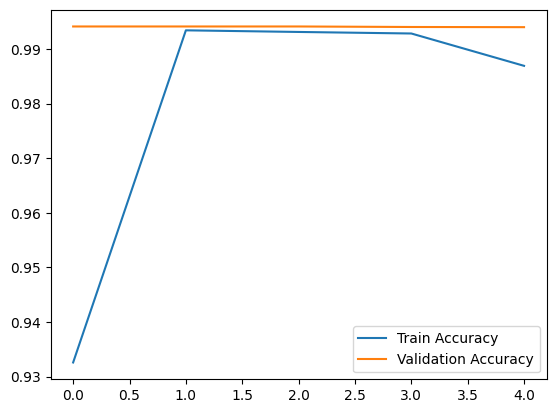

In [138]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


# Save & Load the Model

In [17]:
#model.save("toxic_comment_model.keras")



In [18]:
model = tf.keras.models.load_model("toxic_comment_model.keras")


# Deploy with Gradio

In [19]:
import gradio as gr

# Prediction function
def classify_comment(comment):
    seq = tokenizer.texts_to_sequences([comment])
    padded_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    prediction = model.predict(padded_seq)[0]
    
    labels = df.columns[2:]  # Toxic categories
    results = {label: bool(pred > 0.5) for label, pred in zip(labels, prediction)}
    
    return results

# Create Gradio Interface
interface = gr.Interface(
    fn=classify_comment,
    inputs=gr.Textbox(placeholder="Enter a comment..."),
    outputs="json",
    title="Toxic Comment Detector",
    description="Enter a comment to check if it is toxic or not."
)

# Launch App
interface.launch()


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
